# BCycle all-data Cleaning 

This notebook cleans up the entire dataset provided from BCycle. This dataset has the following columns:

* `Membership Type`: Text categorical column. Some memberships were renamed during the course of BCycle's operation.
* `Bike`: Integer identifier for the bike used in each trip.
* `Checkout Date`: MM/DD/YY formatted date of the checkout
* `Checkout Time`: HH:MM AM/PM formatted time of the checkout.
* `Checkout Kiosk`: The kiosk where the bike trip started.
* `Return Kiosk`: The kiosk where the bike trip ended.
* `Duration (Minutes)`:  Integer length of bike trip (rounded?).

When cleaning up the data, there are many plots to check distributions and correlations.

## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Helper functions

Before getting started on the data analysis, let's define a few useful functions we can call to plot data and reproduce the same analysis.

In [2]:
def plot_lines(df, subplots, title, xlabel, ylabel):
    '''Generates one or more line plots from pandas dataframe'''
    
    fig, ax = subplots
    ax = df.plot.line(ax=ax)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   


# Load raw trip data

The `scripts/clean_xls_data.py` script reads in Excel sheets from the `data/AustinBcycleTripData` directory, parses them and writes out a single CSV file. We need to read this in.

As well as reading the file, there are many rows where the same station is referred to slightly differently. These are shown below. We need to change them to all have the exact same name, as they really refer to the same station.

* East 11th Street at Victory Grill -> East 11th St. at Victory Grill
* ACC - West & 12th Street -> ACC - West & 12th

In [3]:
trip_df = pd.read_csv('../input/all_trips.csv')
trip_df.columns = ['membership', 'bike_id', 'checkout_date', 'checkout_time', 'checkout_kiosk', 'checkin_kiosk', 'duration']
trip_df['checkout_kiosk'] = trip_df['checkout_kiosk'].replace('East 11th Street at Victory Grill', 'East 11th St. at Victory Grill')
trip_df['checkin_kiosk'] = trip_df['checkin_kiosk'].replace('East 11th Street at Victory Grill', 'East 11th St. at Victory Grill')

trip_df['checkout_kiosk'] = trip_df['checkout_kiosk'].replace('ACC - West & 12th Street', 'ACC - West & 12th')
trip_df['checkin_kiosk'] = trip_df['checkin_kiosk'].replace('ACC - West & 12th Street', 'ACC - West & 12th')

# Processing Time and Date

First up is the date and time information. The `checkout_date` column is stored as a date in Excel, so it automatically converts it to `datetime` in pandas. But the `checkout_time` column is stored as text, so we need to convert it. 

After we combine the date and time, we can set this as the index of the dataframe which let us use all the next pandas timeseries functions.

In [4]:
# Combine the date and time columns, use this as the index
def combine_date_time(df, new_col, date_col, time_col, set_index=True, drop=True):
    '''Combines `date_col` and `time_col` into a single datetime column
    INPUT: df - Dataframe to operate on
           date_col - string name of the date column
           time_col - string name of the time column
           set_index - bool whether to set as index after combining
           drop - bool whether to drop original columns afterwards
    RETURNS: Transformed dataframe
    '''

    if new_col != df.index.name:
        df[new_col] = pd.to_datetime(df[date_col] + ' ' + df[time_col])
        # trip_df = trip_df.sort_values('datetime')
        if set_index:
            df = df.set_index(new_col, drop=True)

        if drop:
            df = df.drop([date_col, time_col], axis=1)

    return df
    
trip_df = combine_date_time(trip_df, new_col='datetime', date_col='checkout_date', time_col='checkout_time')
print('Dataframe shape is {}'.format(trip_df.shape))
# print('Top rows:\n{}'.format(trip_df.head()))
# print('Bottom rows:\n{}'.format(trip_df.tail()))

print('Bikes dataframe date range from {} to {}'.format(trip_df.index[0], trip_df.index[-1]))

Dataframe shape is (552916, 5)
Bikes dataframe date range from 2013-12-21 09:09:00 to 2016-12-31 19:13:29


### Plotting weekly rentals

Let's plot the weekly rentals, to get a feel for how the data varies

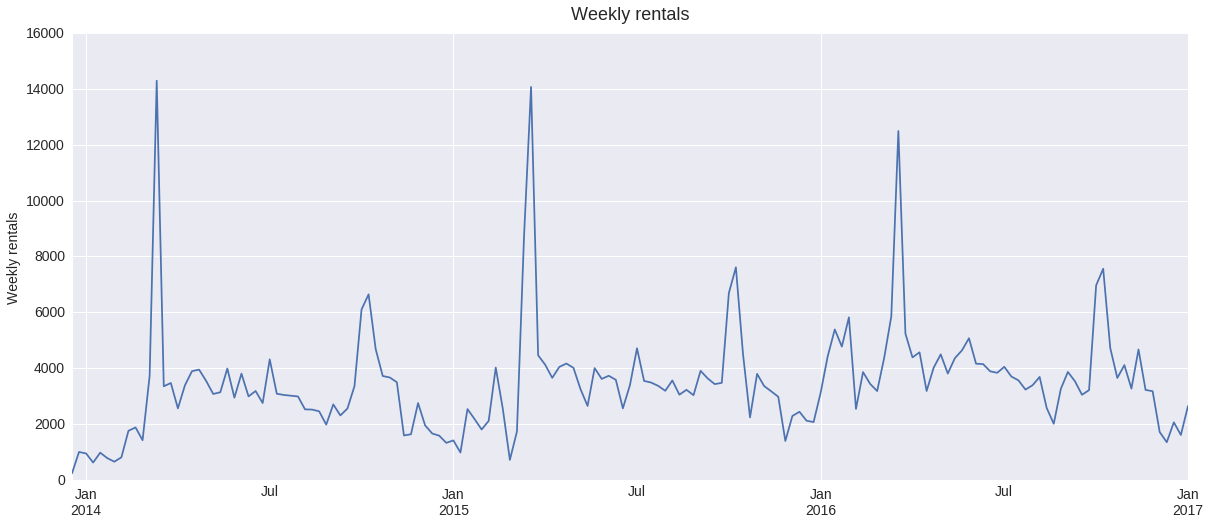

In [5]:
trip_df.resample('W').size().head()
plot_lines(trip_df.resample('W').size(), plt.subplots(1,1, figsize=(20,8)), 
           title='Weekly rentals', xlabel='', ylabel='Weekly rentals')

The rentals show that over the period of 3 years, the amount of rentals is increasing slightly, with 2014 rentals averaging around 3000 per week, 2015 is just under 4000, and 2016 is over 4000. There are also monthly variations, presumably due to the weather.

There are two obvious outliers in the rentals graph which happen every year around the same time. 

* The first is in mid-March, which corresponds to the [SXSW Festival](https://www.sxsw.com). This festival lasts for 7 - 10 days and is split between Interactive, Film, and Music tracks. The Interactive festival is centred on the Austin Convention Center, and during the Music section many venues all around the downtown area and East 6th Street play host to new bands. The peak rentals is ~14000 in both 2014 and 2015, dropping slightly to ~12000 in 2016.


* The second is in early October, when the [ACL Festival](https://www.aclfestival.com) happens. This is a huge music festival split over the first two weekends in October. The festival is held at Zilker Park. This peak is around ~6500 in 2014, increasing to just under 8000 in 2015 and 2016.

# Processing Memberships

The BCycle Membership scheme has been revamped several times during the course of the program. To keep the analysis simple, let's group the membership types into some simpler categories.

In [6]:
# Let's see how many different types of membership there are
memberships_df = trip_df.groupby('membership').size()
print('Found {} different memberships:\n'.format(memberships_df.shape[0]))
print(memberships_df)

Found 51 different memberships:

membership
24-Hour Kiosk (Austin B-cycle)                   108672
24-Hour Membership (Austin B-cycle)                   1
24-Hour-Online (Austin B-cycle)                     737
7-Day                                              3137
7-Day Membership (Austin B-cycle)                  2760
ACL Weekend Pass Special (Austin B-cycle)           329
Annual                                              605
Annual                                               18
Annual (Boulder B-cycle)                            129
Annual (Broward B-cycle)                            142
Annual (Cincy Red Bike)                              51
Annual (Denver B-cycle)                             232
Annual (Denver Bike Sharing)                        131
Annual (Kansas City B-cycle)                         51
Annual (Madison B-cycle)                            165
Annual (Nashville B-cycle)                           27
Annual (Omaha B-cycle)                                3
Annu

We'll use some regexes to combine the categories, to make it more readable I included '...' below to show it matches any following characters.

* `Single` <- 'Ridescout Single Ride', 'Try Before You Buy Special'
* `Day` <- '24-Hour ...', 'Explorer ...', 'Walk up ...'
* `Weekend` <- 'ACL Weekend Pass ...', 'FunFunFun ...', 'Weekender ...'
* `Weekly` <- '7-Day ...'
* `Monthly` <- 'Local30 ...'
* `Semester` <- 'Semester ...'
* `Annual` <- 'Annual ...', 'Local365 ...', 'Membership: pay once  one-year commitment', 'Republic Rider'
* `Tri-Annual` <- 'Founding Member ...'

There are a couple of other types labelled as `PROHIBITED` (8) and `RESTRICTED` (10). We'll drop these as there are only a small number of them, and many of these trips were 0 minutes long.

In [7]:
def clean_memberships(df, col):
    '''Cleans memberships by consolidating and converting to categories
    INPUT: df - pandas Dataframe containing membership columns
           col - column name to be consolidated
    RETURNS: pandas DataFrame with consolidated memberships'''
    
    # Replace the various memberships with their groupings
    df[col] = df[col].astype(str)
    df[col] = df[col].replace(['RideScout Single Ride','Try Before You Buy Special'], value='single')
    df[col] = df[col].replace(['^24-Hour.*$', '^Explorer.*$', '^Walk Up$'], value='day', regex=True)
    df[col] = df[col].replace(['^ACL Weekend Pass.*$', '^FunFunFun.*$', '^Weekender.*$'], value='weekend', regex=True)
    df[col] = df[col].replace(['^7-Day.*$'], value='week', regex=True)
    df[col] = df[col].replace(['^Local30.*$'], value='month', regex=True)
    df[col] = df[col].replace(['^Semester.*$'], value='semester', regex=True)
    df[col] = df[col].replace(['^Annual.*$', '^Local365.*$', 'Republic Rider.*$', '^Membership: pay once  one-year.*$'], value='year', regex=True)
    df[col] = df[col].replace(['^Founding Member.*$', '^.*Founder.*$'], value='triannual', regex=True)

    # Drop the remaining trips (PROHIBITED and RESTRICTED)
    drop_mask = (df['membership'] == 'PROHIBITED') | (df['membership'] == 'RESTRICTED')
    df = df[~drop_mask]
    
    # Finally convert to categorical
    df[col] = df[col].astype('category')
    return df
    
trip_df = clean_memberships(trip_df, 'membership')

print(trip_df.groupby('membership').size())
print(trip_df.info())

membership
day          353501
month         27879
semester       3326
single          960
triannual      6429
week           5897
weekend       14585
year         140321
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 552898 entries, 2013-12-21 09:09:00 to 2016-12-31 19:13:29
Data columns (total 5 columns):
membership        552898 non-null category
bike_id           552898 non-null object
checkout_kiosk    552898 non-null object
checkin_kiosk     552898 non-null object
duration          552898 non-null int64
dtypes: category(1), int64(1), object(3)
memory usage: 21.6+ MB
None


/home/tim/anaconda3/envs/ds450_env/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Visualizing membership types

Now we've converted all the many memberships into 8 final categories based on their length, we can visualize them more easily.

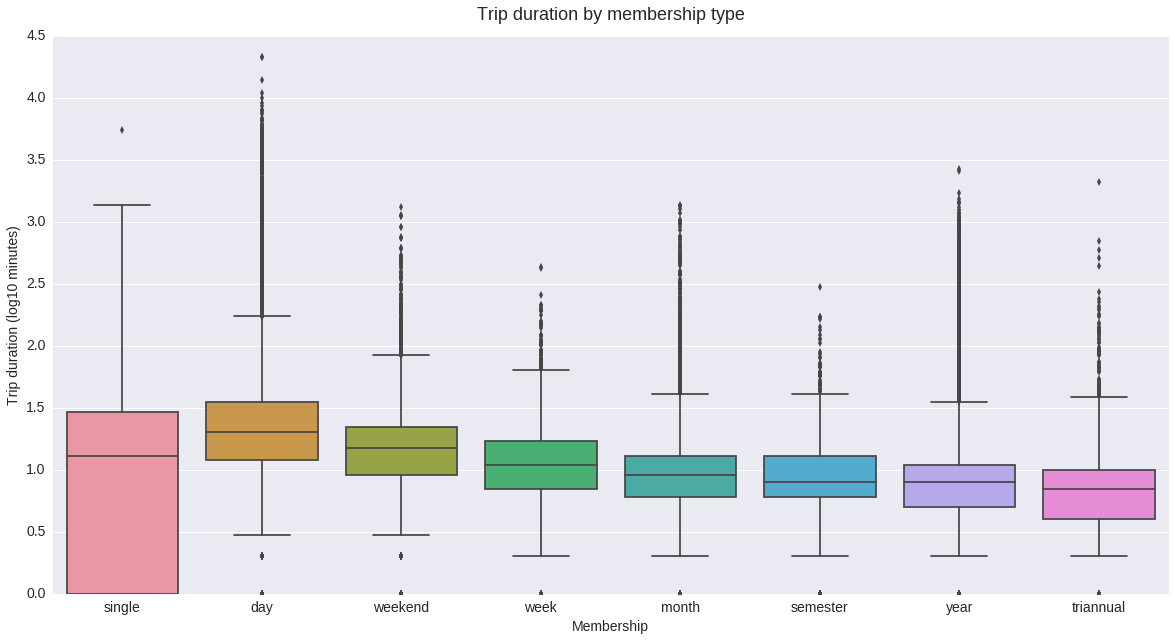

In [8]:
# Show histogram of trip duration by membership type
# g = sns.FacetGrid(trip_df, row='membership', sharey=False, sharex=False, margin_titles=True, size=4)
# g.map(plt.hist, 'duration')
trip_df 

membership_order = ['single', 'day', 'weekend', 'week', 'month', 'semester', 'year', 'triannual']

def plot_boxplot(df, order, x, y, figsize, title, xlabel, ylabel):
    '''Plots a boxplot using given '''
    fig, ax = plt.subplots(1,1, figsize=figsize)  
    ax = sns.boxplot(data=df, x=x, y=y, order=order)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18})
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ttl = ax.title
    ttl.set_position([.5, 1.02])

# Log-transform the durations to compress range
trip_df['log_duration'] = trip_df['duration'].apply(np.log10)
plot_boxplot(trip_df, order=membership_order, x='membership', y='log_duration', figsize=(20,10),
            title='Trip duration by membership type', xlabel='Membership', ylabel='Trip duration (log10 minutes)')
# sns.boxplot(data=trip_df, x='membership', y='duration')

# g = sns.FacetGrid(tips, row="sex", col="time", margin_titles=True)
# bins = np.linspace(0, 60, 13)
# g.map(plt.hist, "total_bill", color="steelblue", bins=bins, lw=0)


Wow ! There are some huge ranges of trip durations here. Even after applying a log10 transformation to the values, there are still many outliers above the third quartile. This shows a heavily right-skewed distribution. There are also a lot of trips that are very short (0 in log10 units is 1 minute). These will need cleaning up.

Interestingly, the median length of trips and 1Q/3Q values decreases as the length of the membership goes up. This suggests people with a shorter membership make longer trips on average, and vice versa. The `single` membership has a 50% of the trips less than 10 minutes in length, perhaps because people were using a 'try-before-you-buy' special.

In [9]:
# Show some of the longest trips
trip_df.sort_values('duration', ascending=False).head(10)

,membership,bike_id,checkout_kiosk,checkin_kiosk,duration,log_duration
datetime,,,,,,
2016-01-07 17:02:35,day,19,Barton Springs @ Kinney Ave,Stolen,21296,4.328298
2016-01-07 17:02:35,day,19,Barton Springs @ Kinney Ave,Stolen,21296,4.328298
2015-12-17 20:18:00,day,8,Pfluger Bridge @ W 2nd Street,Stolen,13981,4.145538
2016-05-22 06:27:11,day,127,West & 6th St.,South Congress & Elizabeth,10981,4.040642
2016-12-23 18:36:54,day,563,Bullock Museum @ Congress & MLK,Stolen,9913,3.996205
2015-11-21 02:21:31,day,843,West & 6th St.,Repair Shop,9118,3.959900
2016-06-22 15:30:57,day,224,Guadalupe & 21st,Red River & 8th Street,8657,3.937367
2016-03-19 02:00:21,day,709,Trinity & 6th Street,Main Office,7905,3.897902
2015-11-25 03:48:40,day,545,Trinity & 6th Street,Stolen,7902,3.897737


There are some common patterns to the ultra-long rentals. A lot of them have `Stolen` or `Missing` as their checkin kiosk, which shows they're not really trips but a way of recording theft. There are also some `Repair Shop`, `Shop`, and `Main Office` trips which are probably a bike needing maintenance.

These outliers should all be dropped by the time we have the dataset in a clean form below. We'll re-run this query again then, and make sure it looks better.

In [10]:
# What are the stats for single memberships?
trip_df.loc[trip_df['membership'] == 'single', 'duration'].describe()

count     960.000000
mean       33.129167
std       192.049220
min         0.000000
25%         1.000000
50%        13.000000
75%        29.000000
max      5493.000000
Name: duration, dtype: float64

The single membership trip durations are very heavily right skewed. 25% of the trips are 1 minute or less (!) - either people with `single` memberships are **really** fast at cycling, or they're just taking a very short trip.

### Plotting trips by each membership type by year

Let's plot how the membership types vary over year. We'll use 2014, 2015, and 2016 as we have full years of data for these.

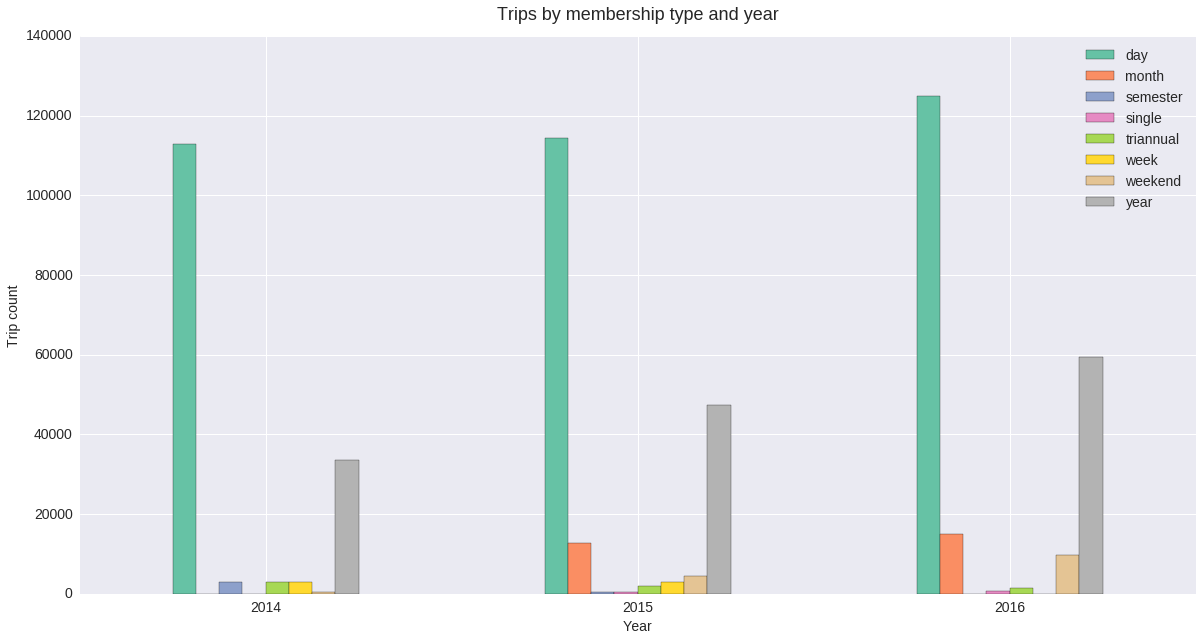

In [11]:
# todo - Add in the trips by membership type
plot_df = trip_df.copy()
plot_df['year'] = plot_df.index.year
plot_df = plot_df['2014-01-01':'2016-12-31'].groupby(['year', 'membership']).size().reset_index(name='count')
plot_df = plot_df.pivot_table(index='year', columns='membership', values='count')
plot_df = plot_df.fillna(0)

def plot_bar(df, size, title, xlabel, ylabel):
    '''Plots a bar graph of the dataframe '''
    
    palette = sns.color_palette('Set2', len(df.columns)) # Don't repeat colours
    fig, ax = plt.subplots(1, 1, figsize=size)
    ax = df.plot.bar(ax=ax, color=palette, rot=0)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   
    ax.legend(fontsize = 14)

plot_bar(plot_df, (20,10), title='Trips by membership type and year', xlabel='Year', ylabel='Trip count')

This plot contains quite a bit of information. Remember this is the count of trips by membership type, not the amount of memberships that were sold of each type.

The first observation is that day memberships account for the vast majority of trips in every year, followed by the yearly memberships at around half the trip count, and then monthly memberships. Trips by other memberships are low compared to these. The trips by weekend members is growing rapidly from a small initial value.

# Processing Bike IDs

Now we need to convert the bike IDs to numeric values and convert to a categorical type. First of all let's check there aren't any non-numeric values in the dataset.

In [12]:
# Find all the bike_id values that aren't numeric
print('Checking for non-numeric bike ids:')
text_row_mask = trip_df['bike_id'].str.contains('\D')
text_bikes_df = trip_df[text_row_mask]
bike_str_ids = text_bikes_df['bike_id'].unique()
print('Found non-numeric bike ids: {}'.format(bike_str_ids))


Checking for non-numeric bike ids:
Found non-numeric bike ids: ['Block01' '198BB' 'Block03' 'Block05' 'Block02' 'Block04']


In [13]:
# Check how many `bike_id`s are non-numeric and drop them
n_rows = trip_df.shape[0]
n_str_rows = np.sum(text_row_mask)
pct_str_rows = (n_str_rows / n_rows) * 100.0
print('Total rows: {}\n'.format(n_rows))
print('Total non-numeric `bike_id` values: {} or {:.1f}% of rows\n'.format(n_str_rows, pct_str_rows))
print('Non-numeric `bike_id` counts: \n{}'.format(text_bikes_df.groupby('bike_id').size()))

if n_str_rows != 0:
    trip_df = trip_df[~text_row_mask]
    assert np.sum(trip_df['bike_id'].str.contains('\D')) == 0, 'Error - still non-numeric bike_ids left !'
    
print('Max bike ID is {}'.format(trip_df['bike_id'].max()))
trip_df['bike_id'] = trip_df['bike_id'].astype(np.uint16)
trip_df.head()

Total rows: 552898

Total non-numeric `bike_id` values: 726 or 0.1% of rows

Non-numeric `bike_id` counts: 
bike_id
198BB      683
Block01      7
Block02     15
Block03      4
Block04     11
Block05      6
dtype: int64
Max bike ID is 999


,membership,bike_id,checkout_kiosk,checkin_kiosk,duration,log_duration
datetime,,,,,,
2013-12-21 09:09:00,triannual,966,4th & Congress,Republic Square,5,0.698970
2013-12-21 18:36:00,year,453,South Congress & Elizabeth,5th & Bowie,10,1.000000
2013-12-21 18:04:00,triannual,116,2nd & Congress,4th & Congress,5,0.698970
2013-12-21 17:56:00,triannual,971,5th & Bowie,2nd & Congress,7,0.845098
2013-12-21 17:49:00,day,14,Barton Springs & Riverside,City Hall / Lavaca & 2nd,6,0.778151


count     408.000000
mean     1353.362745
std       299.712993
min        17.000000
25%      1264.500000
50%      1427.500000
75%      1534.000000
max      1780.000000
dtype: float64

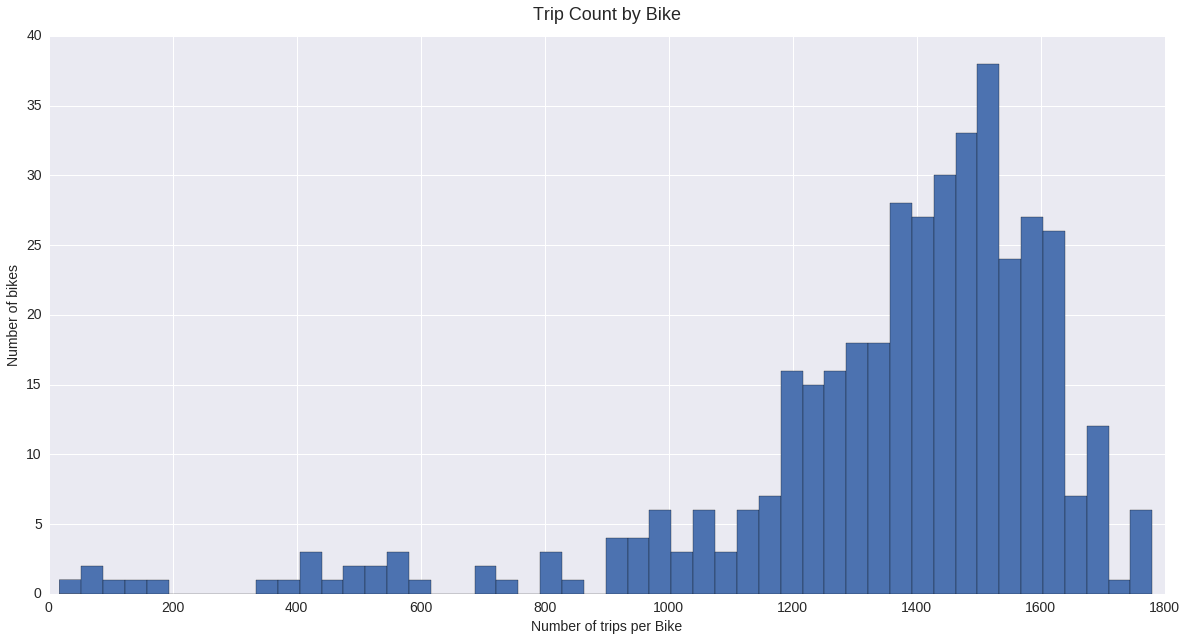

In [14]:
# Let's see how many times each of the bikes were rented out

def plot_hist(df_col, bins, size, title, xlabel, ylabel):
    '''Plots a histogram of the dataframe column'''
    
    fig, ax = plt.subplots(1, 1, figsize=size)
    ax = df_col.plot.hist(ax=ax, bins=bins)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   

bikes_df = trip_df.groupby('bike_id').size()
plot_hist(bikes_df, bins=50, size=(20,10), 
          title='Trip Count by Bike', 
          xlabel='Number of trips per Bike', 
          ylabel='Number of bikes')

bikes_df.describe()    

The histogram above shows that the most common number of trips for a given bike is around 1427. The distribution of trips per bike is left-skewed, with the Inter-Quartile-Range from 1264 to 1534 trips per bike. These bikes must be well maintained to make well over a thousand trips per bike !

# Processing stations

Now we need to convert the checkin and checkout kiosks into a categorical type instead of a string type. Let's do some checks to see what the overlap is like between checkin and checkout.

In [15]:
# Create a set of all the checkout and checkin kiosks. 
# If the sizes are different we have some checkin or checkout only ones.
checkins = set(trip_df['checkin_kiosk'].unique())
checkouts = set(trip_df['checkout_kiosk'].unique())

print('Number of unique checkin kiosks: {}, checkout kiosks: {}'.format(len(checkins), len(checkouts)))

Number of unique checkin kiosks: 84, checkout kiosks: 82


In [16]:
# Hmm ! Let's see which stations are in checkin and checkout, and which are in one only

def venn_stats(left, right, verbose=False, left_name=None, right_name=None):
    '''Creates Venn Diagram stats for two sets, left and right
    INPUTS: left = set of items on left
            right = set of items on right
            verbose = bool to print out set overlap and count info
            left_name = string used if verbose == True. Describes left set
            right_name = string used if verbose == True. Describes right set
    '''
    left_only = left - right
    left_and_right = left & right
    right_only = right - left
    
    if verbose:
        print('{} size = {}, {} size = {}'.format(left_name, len(left), right_name, len(right)))
        print('\nIntersection of {} and {} ({}):\n{}'.format(left_name, right_name, len(left_and_right), left_and_right))
        print('\n{}-only ({}):\n{}'.format(left_name, len(left_only), left_only))
        print('\n{}-only ({}):\n{}'.format(right_name, len(right_only), right_only))

    return (left_only, left_and_right, right_only)

venn_stations = venn_stats(checkouts, checkins, 
                          verbose=True, left_name='checkout', right_name='checkin')

checkout_only_stations, common_stations, checkin_only_stations = venn_stations

checkout size = 82, checkin size = 84

Intersection of checkout and checkin (81):
{'Rainey St @ Cummings', 'State Capitol @ 14th & Colorado', 'South Congress & Elizabeth', 'Main Office', 'East 11th St. at Victory Grill', '5th & Bowie', 'Red River & 8th Street', 'Mobile Station @ Boardwalk Opening Ceremony', 'Republic Square @ Federal Courthouse Plaza', 'State Parking Garage @ Brazos & 18th', 'MapJam at French Legation', 'Plaza Saltillo', 'Capitol Station / Congress & 11th', '5th & San Marcos', 'Barton Springs Pool', 'Brazos & 6th', 'Repair Shop', 'MapJam at Pan Am Park', 'Republic Square', 'Convention Center / 4th St. @ MetroRail', 'MapJam at Scoot Inn', 'MapJam at Hops & Grain Brewery', 'Re-branding', 'City Hall / Lavaca & 2nd', 'Mobile Station', 'Rainey @ River St', 'South Congress & Academy', 'Zilker Park at Barton Springs & William Barton Drive', 'Trinity & 6th Street', 'Red River @ LBJ Library', 'Marketing Event', 'South Congress & Barton Springs at the Austin American-Statesman',

### Checkout-only stations

Let's see how many trips stations only found in the `checkout_kiosk` columns. If there are only a small proportion, we can drop these. Otherwise we need to include them (but there's no obvious reason why a station would be checkin or checkout only).

In [17]:
# Let's deal with the checkin and checkout only stations
checkout_only_mask = trip_df['checkout_kiosk'].isin(checkout_only_stations)
checkout_only_count = np.sum(checkout_only_mask)
all_rows_count = trip_df.shape[0]
checkout_only_pct = (checkout_only_count / all_rows_count) * 100.0
checkout_only_df = trip_df[checkout_only_mask]
print('Number of checkout-only rows: {}, {:.4f}% of total'.format(checkout_only_count, checkout_only_pct))

if checkout_only_count > 0:
    trip_df = trip_df[~checkout_only_mask]
print('Trips Dataframe shape is {}'.format(trip_df.shape))
checkout_only_df.groupby('checkout_kiosk').size()

Number of checkout-only rows: 8, 0.0014% of total
Trips Dataframe shape is (552164, 6)


checkout_kiosk
Fantasy Zilker    8
dtype: int64

The stations above are only in the `checkout_kiosk` column, and never in the `checkin_kiosk` column. There are only 8 rows, which all leave from 'Fantasy Zilker' in the first 2 weekends of October 2016. I suspect this might be a special event held in Zilker Part. As there are only 8 of these rows, we can drop them from the dataset.

### Checkin-only stations

Now we can see which station names are only in the `checkin_kiosk` column, and not the `checkout_kiosk` column. It's hard to think of a reason why trips would only end at a station, and not begin from the same one over the course of multiple years. 

In [18]:
checkin_only_mask = trip_df['checkin_kiosk'].isin(checkin_only_stations)
checkin_only_count = np.sum(checkin_only_mask)
all_rows_count = trip_df.shape[0]
checkin_only_pct = (checkin_only_count / all_rows_count) * 100.0
checkin_only_df = trip_df[checkin_only_mask]
print('Number of checkin-only rows: {}'.format(checkin_only_df.shape[0]))

if checkin_only_count > 0:
    trip_df = trip_df[~checkin_only_mask]
print('Trips Dataframe shape is {}'.format(trip_df.shape))
checkin_only_df.groupby('checkin_kiosk').size()

Number of checkin-only rows: 69
Trips Dataframe shape is (552095, 6)


checkin_kiosk
Main Shop     2
Missing      25
Stolen       42
dtype: int64

There are only 69 checkin-only rows, from one of the three types: Main Shop, Missing, and Stolen. I think the 'Main Shop' ones might have been returned to the BCycle maintenance office for repair. Stolen bikes are self explanatory, the 'Missing' ones must be the ones that have gone missing, but not yet returned. We can drop these rows.

## Counting checkins and checkouts at stations

Now we're left with only stations that are in both the checkout and checkin columns on the full dataset. We can count up all the checkins and checkouts at each of the stations. Then we can sum up the totals by station. Let's create this dataframe, and then create a barplot to see how the checkouts and checkins vary by station.

In [19]:
# Now all stations are common in checkin and checkout
checkouts_df = trip_df.groupby('checkout_kiosk').size().to_frame('checkouts').reset_index()
checkins_df = trip_df.groupby('checkin_kiosk').size().to_frame('checkins').reset_index()
station_df = pd.merge(checkins_df, checkouts_df, left_on='checkin_kiosk', right_on='checkout_kiosk')
station_df = station_df.drop('checkout_kiosk', axis=1)
station_df.columns = ['name', 'checkins', 'checkouts']
station_df['total'] = station_df['checkins'] + station_df['checkouts']
station_df = station_df.sort_values('total', ascending=False).reset_index(drop=True)
station_df.head()

,name,checkins,checkouts,total
0,City Hall / Lavaca & 2nd,29320,25149,54469
1,Riverside @ S. Lamar,23837,24529,48366
2,2nd & Congress,25136,22607,47743
3,4th & Congress,24525,21812,46337
4,5th & Bowie,21978,23586,45564


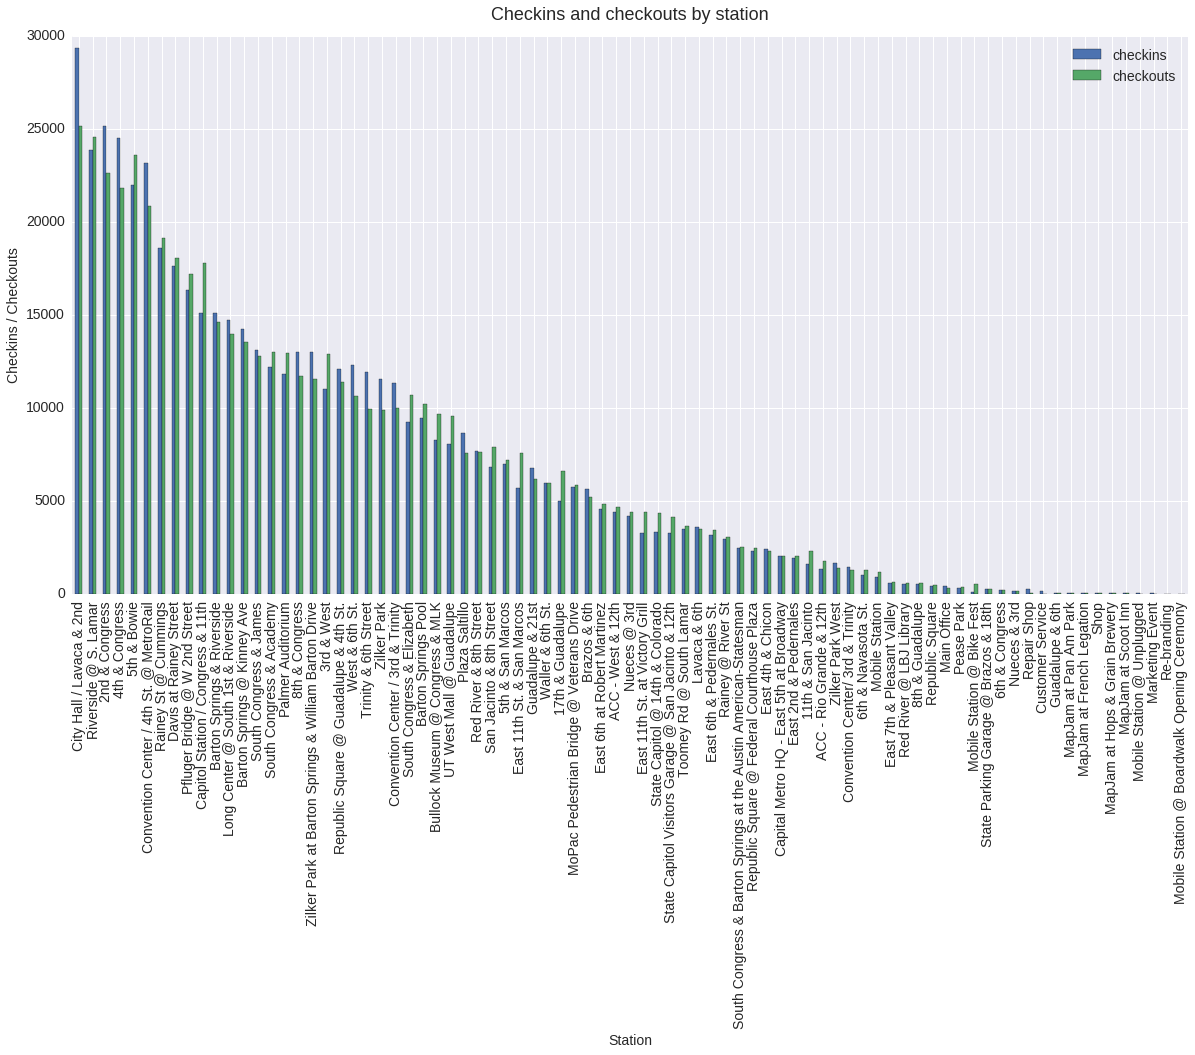

In [20]:
# Create a bar plot of the checkins and checkouts per station
def plot_bar(df, x, y, size, title, xlabel, ylabel):
    '''Plots a bar-graph of dataframe column'''
    
    fig, ax = plt.subplots(1, 1, figsize=size)
    ax = df.plot.bar(ax=ax, x=x, y=y)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   
    ax.legend(fontsize = 14)


plot_bar(station_df, x='name', y=['checkins', 'checkouts'], size=(20,10), 
         title='Checkins and checkouts by station',
        xlabel='Station', ylabel='Checkins / Checkouts')


This is a very busy plot, and too condensed to easily read the station names. But you can see the rough distribution of checkins and checkouts from the busiest stations (City Hall, Riverside @ S. Lamar, 2nd & Congress, etc) down to the quietest stations ('Marketing Event', 'Mobile Station @ Boardwalk Opening', 'Re-branding'). As you get to the quieter stations, they seem to be temporary stations at events, or codenames for maintenance on the bikes: 'Shop'.

In [21]:
# Now let's print out all the stations, and drop ones which seem temporary

def remove_rows(df, col, words, verbose=False):
    '''Removes rows containing words given
    INPUT: df - dataframe
           words - iterable containing words
    RETURNS: Dataframe with rows containing `words` removed
    '''
    new_df = df.copy()
    for word in words:
        drop_mask = new_df[col].str.contains(word)
        drop_count = np.sum(drop_mask)
        drop_df = new_df[drop_mask]
        print('Dropping {} rows containing {}:\n{}'.format(drop_count, word, drop_df[col]))
        if (drop_count > 0):
            new_df = new_df[~drop_mask]
    return new_df.reset_index(drop=True)


station_df = remove_rows(station_df, 'name', 
                 ['MapJam', 'Mobile', 'Shop', 'Marketing', 'Re-branding', 
                  'Customer Service', 'Main Office'],
                 verbose=True)
station_df = station_df.sort_values('name').reset_index(drop=True)
station_df['station_id'] = range(station_df.shape[0])
station_df['station_id'] = station_df['station_id'] + 1
station_df.head()

Dropping 4 rows containing MapJam:
72             MapJam at Pan Am Park
73         MapJam at French Legation
75    MapJam at Hops & Grain Brewery
76               MapJam at Scoot Inn
Name: name, dtype: object
Dropping 4 rows containing Mobile:
58                                 Mobile Station
65                     Mobile Station @ Bike Fest
77                     Mobile Station @ Unplugged
80    Mobile Station @ Boardwalk Opening Ceremony
Name: name, dtype: object
Dropping 2 rows containing Shop:
69    Repair Shop
74           Shop
Name: name, dtype: object
Dropping 1 rows containing Marketing:
78    Marketing Event
Name: name, dtype: object
Dropping 1 rows containing Re-branding:
79    Re-branding
Name: name, dtype: object
Dropping 1 rows containing Customer Service:
70    Customer Service
Name: name, dtype: object
Dropping 1 rows containing Main Office:
63    Main Office
Name: name, dtype: object


,name,checkins,checkouts,total,station_id
0,11th & San Jacinto,1576,2301,3877,1
1,17th & Guadalupe,4993,6620,11613,2
2,2nd & Congress,25136,22607,47743,3
3,3rd & West,10987,12889,23876,4
4,4th & Congress,24525,21812,46337,5


### Re-ploting checkins and checkouts by station (after dropping invalid stations)

Let's redo the previous bar plot now we dropped the temporary stations and `Shop`, `Repair Shop`, and `Main Office` rows.

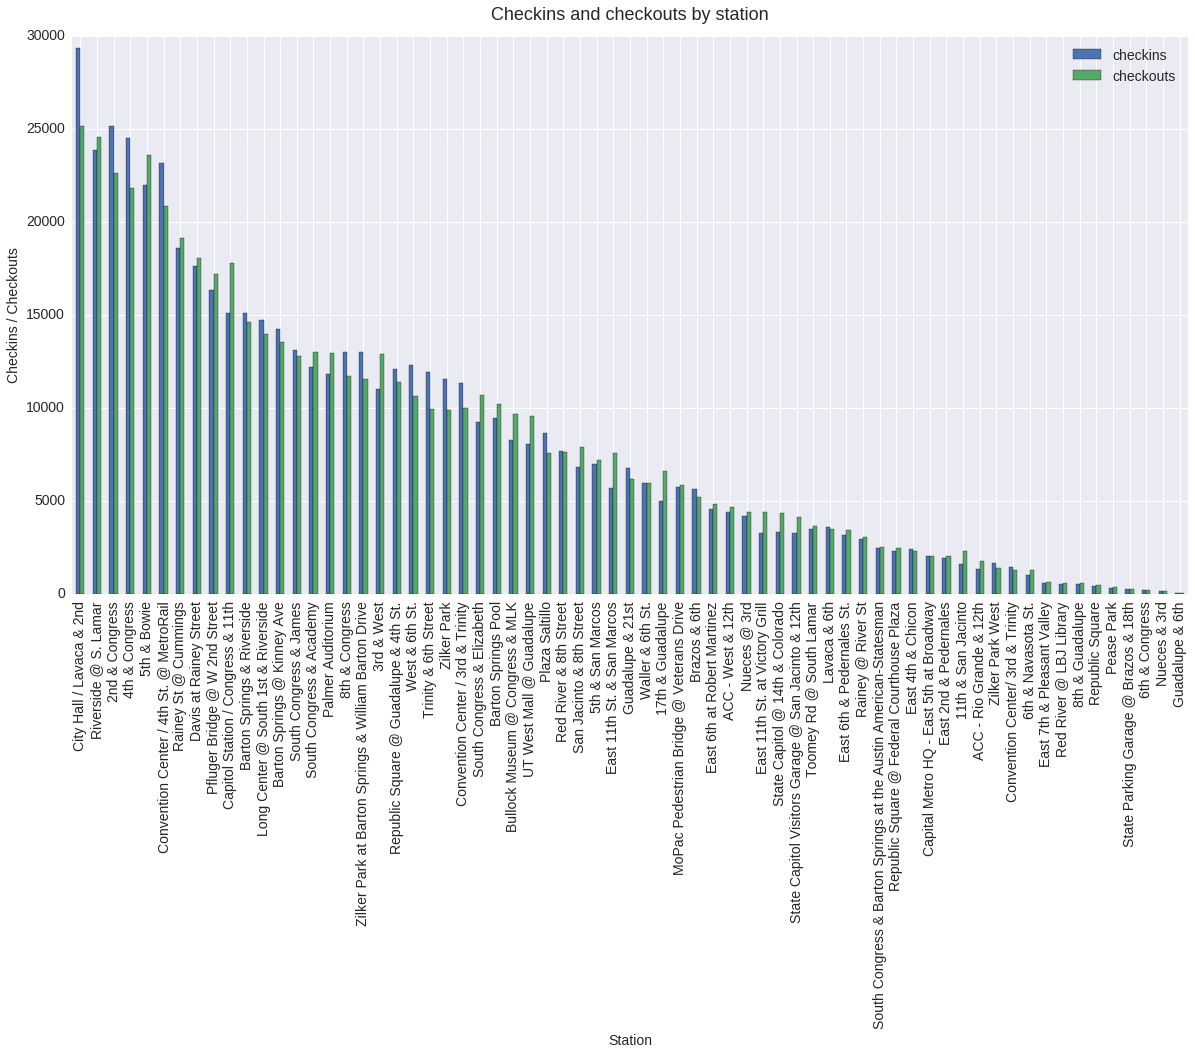

In [22]:
station_df = station_df.sort_values('total', ascending=False)
plot_bar(station_df, x='name', y=['checkins', 'checkouts'], size=(20,10), 
         title='Checkins and checkouts by station',
        xlabel='Station', ylabel='Checkins / Checkouts')

# Adding metadata to stations dataframe

Now we have the stations table separated from the trips, we can add in metadata for the longitude and latitude of each of the stations. These can come from a combination of:

* The Austin Bcycle station: This can be parsed to extract the stations and matched based on the names.
* Google's geocoder: We can fill in any stations not currently on the webpage using geocoding.

In [23]:
import requests
import re

def parse_stations_html(url, verbose=False):
    '''Parses an HTML file at url, returning a dictionary of matches
    INPUT: url string to parse
    RETURNS: dictionary with lat/lon key, and station info as value
    '''
    LAT_IDX = 0
    LONG_IDX = 1

    STAT_NAME = 0
    STAT_ADDRESS = 1
    STAT_BIKES = 2
    STAT_DOCKS = 3
    
    date_re = re.compile('.*stations_(\d{4}-\d{2}-\d{2}).*\.html')
    time_re = re.compile('.*stations_\d{4}-\d{2}-\d{2}_(\d{2}:\d{2}:)\d{2}.*\.html')
    # The `Convention Center / 4th St. @ MetroRail` station has a bug in the HTML.
    station_re = re.compile('^var marker = new createMarker\(point, \"<div class=\'markerTitle\'>'
                            '<h3>(\w.*)</h3></div><div class=\'markerPublicText\'><.+></div>'
                            '<div class=\'markerAddress\'>(\w.*)</div><div class=\'markerAvail\'>'
                            '<div style=\'float: left; width: 50%\'><h3>(\d+)</h3>Bikes</div>'
                            '<div style=\'float: left; width: 50%\'><h3>(\d+)</h3>Docks</div></div>\".*$')
    latlong_re = re.compile('var point = new google\.maps\.LatLng\((.+), (.+)\);')

    # Dictionary to store stations
    stations = dict()
    
    r = requests.get(url, stream=True)

    location_count = 0
    station_count = 0
    lat = -1
    lon = -1
    def parse_latlon(line, regex):
        '''Helper function to parse latitude and longitude to tuple'''
        match = regex.match(line)
        if (match != None):
            latitude = float(regex.match(line).groups()[LAT_IDX])
            longitude = float(regex.match(line).groups()[LONG_IDX])
            latlon = (latitude, longitude)
            return latlon
        return None

    def parse_station(line, regex):
        '''Helper function to parse station info into dict'''
        
        match = regex.match(line)
        if (match != None):
            name = str(regex.match(line).groups()[STAT_NAME])
            address = str(regex.match(line).groups()[STAT_ADDRESS].replace('<br />', ', '))
            bikes = int(regex.match(line).groups()[STAT_BIKES])
            docks = int(regex.match(line).groups()[STAT_DOCKS])

            new_station = dict()
            new_station['name'] = name
            new_station['address'] = address
            return new_station
        
        return None
            
        
    for line in r.iter_lines():
        if line:
            decoded_line = line.decode('utf-8')
            
            latlon = parse_latlon(decoded_line, latlong_re)
            if latlon is not None:
                location_count += 1
                lat, lon = latlon
                if verbose:
                    print('Found location {}: lat {}, lon {}'.format(location_count, latlon[0], latlon[1]))
                continue
                
            new_station = parse_station(decoded_line, station_re)
            if new_station is not None:
                station_count += 1
                new_station['lat'] = lat
                new_station['lon'] = lon
                stations[station_count] = new_station
                if verbose:
                    print('Adding station #{}, {}'.format(station_count, new_station['name']))

    assert station_count == location_count, 'Error - found {} locations, {} stations'.format(station_count, location_count)
    return stations
                    
web_stations = parse_stations_html('https://austin.bcycle.com/stations/station-locations', verbose=False)

web_stations_df = pd.DataFrame.from_dict(web_stations, orient='index')
web_stations_df = web_stations_df.reset_index()
web_stations_df = web_stations_df.rename(columns={'index' : 'station_id'})
web_stations_df = web_stations_df[['station_id', 'name', 'address', 'lat', 'lon']]
print('Current website contains {} stations. Top 6:'.format(web_stations_df.shape[0]))
web_stations_df.head()

Current website contains 50 stations. Top 6:


,station_id,name,address,lat,lon
0,1,2nd & Congress,"151 E. 2nd St, Austin, TX 78701",30.26408,-97.74355
1,2,4th & Congress,"120 W. 4th St., Austin, TX 78701",30.26634,-97.74378
2,3,8th & Congress,"111 E. 8th St., Austin, TX 78701",30.26978,-97.74224
3,4,Capitol Station / Congress & 11th,"1090 Congress Ave., Austin, TX 78701",30.27260,-97.74127
4,5,Convention Center / 4th St. @ MetroRail,"499 E. 4th St, Austin, TX 78701",30.26483,-97.73900


### Looking up remaining station locations

There are dozens of stations in from the full data bike trip which aren't on the current website. These might be older stations which were shut down, or ones which changed name and moved. We need to fill in both a latitude and longitude, as well as an address. We can fill in this missing info using geocoding. 

First of all, let's split the list of all the stations in the bike trips full data into those:

* Which we found information on by scraping the current bicycle location page
* For which we have the name only, not the location information

In [24]:
# Create a dataframe of stations which are in the bike trips DF but not on website
all_stations_df = station_df.copy()
missing_stations_df = all_stations_df[~all_stations_df['name'].isin(web_stations_df['name'])]
missing_stations_df = missing_stations_df['name'].reset_index()

# Number the missing stations starting from the last web scraped one
start_index = web_stations_df.shape[0] + 1
stop_index = start_index + missing_stations_df.shape[0]
missing_station_ids = range(start_index, stop_index)
missing_stations_df['station_id'] = missing_station_ids
missing_stations_df = missing_stations_df[['station_id', 'name']]
print('There are {} missing stations'.format(missing_stations_df.shape[0]))
missing_stations_df

There are 17 missing stations


,station_id,name
0,51,Zilker Park at Barton Springs & William Barton...
1,52,Republic Square @ Guadalupe & 4th St.
2,53,Waller & 6th St.
3,54,ACC - West & 12th
4,55,Nueces @ 3rd
5,56,Toomey Rd @ South Lamar
6,57,Lavaca & 6th
7,58,Rainey @ River St
8,59,ACC - Rio Grande & 12th
9,60,Zilker Park West


In [26]:
from pygeocoder import Geocoder
import re

def geocode(name, verbose=False, dry_run=False):
    '''Tries to geocode a location, returns None if no matches
    INPUT: name - string containing the location
    RETURNS: tuple of (latitude, longitude) if successful, None if not
    '''

    name = re.sub('^ACC - ', '', name)
    name = re.sub('^West & ', 'West Ave & ', name)
    name = re.sub('at the \D.*$', '', name)
    name = re.sub('^Convention Center/', '', name)
    name = re.sub('^State Parking Garage @', '', name)
    name = re.sub('Zilker Park West', 'Zilker Park', name)

    for end in ('rd', 'st', 'th'):
        name = re.sub(end + '$', end + ' Street', name)

    name += ', Austin TX' # Add this on the end to help !
    
    if dry_run:
        print('Looking up {}'.format(name))
        return name
    
    try:
        result = Geocoder.geocode(name)
        if verbose:
            print('Returned {} geocode as {}'.format(name, result.coordinates))
        return result.coordinates
    
    except Exception as e:
        print('** Error finding geocode for {}'.format(name))
        return None

missing_stations_df['latlon'] = missing_stations_df['name'].apply(lambda x: geocode(x, verbose=True))
missing_stations_df

Returned Zilker Park at Barton Springs & William Barton Drive, Austin TX geocode as (30.2660526, -97.76882379999999)
Returned Republic Square @ Guadalupe & 4th St., Austin TX geocode as (30.2679131, -97.74727229999999)
Returned Waller & 6th St., Austin TX geocode as (30.2644054, -97.7305088)
Returned West Ave & 12th Street, Austin TX geocode as (30.2760228, -97.7484401)
Returned Nueces @ 3rd Street, Austin TX geocode as (30.2668455, -97.7494892)
Returned Toomey Rd @ South Lamar, Austin TX geocode as (30.262919, -97.7576709)
Returned Lavaca & 6th Street, Austin TX geocode as (30.2687282, -97.74520539999999)
Returned Rainey @ River St, Austin TX geocode as (30.2577084, -97.7386258)
Returned Rio Grande & 12th Street, Austin TX geocode as (30.2758111, -97.7473268)
Returned Zilker Park, Austin TX geocode as (30.2669624, -97.77285930000001)
Returned  3rd & Trinity, Austin TX geocode as (30.2642785, -97.74035889999999)
Returned 6th & Navasota St., Austin TX geocode as (30.2637215, -97.728495)

,station_id,name,latlon
0,51,Zilker Park at Barton Springs & William Barton...,"(30.2660526, -97.76882379999999)"
1,52,Republic Square @ Guadalupe & 4th St.,"(30.2679131, -97.74727229999999)"
2,53,Waller & 6th St.,"(30.2644054, -97.7305088)"
3,54,ACC - West & 12th,"(30.2760228, -97.7484401)"
4,55,Nueces @ 3rd,"(30.2668455, -97.7494892)"
5,56,Toomey Rd @ South Lamar,"(30.262919, -97.7576709)"
6,57,Lavaca & 6th,"(30.2687282, -97.74520539999999)"
7,58,Rainey @ River St,"(30.2577084, -97.7386258)"
8,59,ACC - Rio Grande & 12th,"(30.2758111, -97.7473268)"
9,60,Zilker Park West,"(30.2669624, -97.77285930000001)"


## Checking geocodes on a map

Now we have geocoded all the stations that aren't on the current BCycle website, we can plot them on a map to sanity check them. The markers are clickable, showing their address.

In [ ]:
import folium

def split_position(df, tuple_col, lat_col, lon_col, drop=True):
    '''Splits a (latitude, longitude) tuple into separate columns
    INPUT: df - dataframe to operate on
           tuple_col - name of the (lat, lon) tuple column
           lat_col - name of the new split latitude column
           lon_col - name of the new split longitude column
    RETURNS: Dataframe with new columns
    '''
    if tuple_col in df.columns:
        df[lat_col] = df[tuple_col].apply(lambda x: x[0])
        df[lon_col] = df[tuple_col].apply(lambda x: x[1])
        if drop:
            df = df.drop(tuple_col, axis=1)
    return df

def map_plot(df, verbose=False):
    '''Plots stations on a map from a dataframe'''
    min_lat = df['lat'].min()
    max_lat = df['lat'].max()
    min_lon = df['lon'].min()
    max_lon = df['lon'].max()
    center_lat = min_lat + (max_lat - min_lat) / 2.0
    center_lon = min_lon + (max_lon - min_lon) / 2.0
    if verbose:
        print('Plotting map centred at ({}, {})'.format(center_lat, center_lon))
    
    # Plot map using the B&W Stamen Toner tiles centred on BCycle stations
    map = folium.Map(location=(center_lat, center_lon), zoom_start=14, 
                     tiles='Stamen Toner', control_scale=True)

    # Add markers to the map for each station. Click on them to see their name
    for station in df.iterrows():
        stat=station[1]
        folium.Marker([stat['lat'], stat['lon']], popup=stat['name'],
                  icon=folium.Icon(icon='info-sign')
                 ).add_to(map)

    map.save('stations.html')
    return map
    
map_plot(split_position(missing_stations_df, 'latlon', 'lat', 'lon'))

### Reverse geocoding to find address from latitude and longitude

Now we have latitude and longitude, we can convert this back into an address. Then all the stations not scraped from the site have the same data as the ones from the site.

In [ ]:
def rev_geocode(latlon, verbose=False):
    '''Tries to reverse geocode a latitude and longitude, returns None if no matches
    INPUT: latlon - 2-tuple containing (latitude, longitude)
    RETURNS: String with address if found
    '''
    try:
        result = Geocoder.reverse_geocode(latlon[0], latlon[1])
        if verbose:
            print('Returned {} geocode as {}'.format(latlon, result))
        return result
    
    except Exception as e:
        print('** Error finding geocode for {}: {}'.format(latlon, e))
        return None

missing_stations_df['address'] = missing_stations_df['latlon'].apply(lambda x: rev_geocode(x, verbose=True))
missing_stations_df.head()

### Splitting latitude and longitude, recombining into web_stations

In [ ]:
missing_stations_df = split_position(missing_stations_df, 'latlon', 'lat', 'lon')
missing_stations_df.head()

### Combining stations back together into single table

In [ ]:
all_stations_df = pd.concat((web_stations_df, missing_stations_df), axis=0)
all_stations_df = all_stations_df.reset_index(drop=True)
print('All stations count: {}'.format(all_stations_df.shape[0]))
all_stations_df.head()

# Normalizing bikes and trips into separate tables

Now we have a clean list of stations, we can use their `station_id` values to link them to the bike trips table. We expect some bike trips to be dropped, as we removed their stations from the cleaned dataframe.

In [ ]:
n_trips = trip_df.shape[0]
print('Before normalizing, bikes_df has {} rows'.format(n_trips))
stations = set(all_stations_df['name'])
print('{} stations in station table'.format(len(stations)))


def venn_stats_df(df, left_col, right_col, verbose=False):
    '''Creates Venn Diagram stats for two sets, left and right
    INPUTS: df - Dataframe with columns to check for overlaps
            left_col = Dataframe column to use as left items
            right_col = Dataframe column to use as right items
            verbose = bool to print out set overlap and count info
    '''
    left = set(df[left_col].unique())
    right = set(df[left_col].unique())

    left_only = left - right
    left_and_right = left & right
    right_only = right - left
    
    if verbose:
        print('{} size = {}, {} size = {}'.format(left_col, len(left), right_col, len(right)))
        print('\nIntersection of {} and {} ({}):\n{}'.format(left_col, right_col, len(left_and_right), left_and_right))
        print('\n{}-only ({}):\n{}'.format(left_col, len(left_only), left_only))
        print('\n{}-only ({}):\n{}'.format(right_col, len(right_only), right_only))

    return (left_only, left_and_right, right_only)

l, m, r = venn_stats_df(trip_df, left_col='checkin_kiosk', right_col='checkout_kiosk', verbose='True')
bike_stations = m

l, m, r = venn_stats(bike_stations, stations, left_name='bike_stations', right_name='station_table', verbose=True)
bike_stations_only = l

bike_stations_only_checkin_mask = trip_df['checkin_kiosk'].isin(bike_stations_only)
bike_stations_only_checkout_mask = trip_df['checkout_kiosk'].isin(bike_stations_only)
bike_stations_only_mask = bike_stations_only_checkin_mask | bike_stations_only_checkout_mask
bike_stations_only_count = np.sum(bike_stations_only_mask)
n_dropped_trips = n_trips - bike_stations_only_count

print('Pre-normalize row count: {}, post-normalize: {}'.format(n_trips, n_dropped_trips))

### Final table splitting and replacement with `station_id` 

In [ ]:
norm_trip_df = pd.merge(trip_df.reset_index(), all_stations_df[['name', 'station_id']], left_on='checkout_kiosk', right_on='name')
norm_trip_df = pd.merge(norm_trip_df, all_stations_df[['name', 'station_id']], left_on='checkin_kiosk', right_on='name')
norm_trip_df = norm_trip_df[['datetime', 'membership', 'bike_id', 'station_id_x', 'station_id_y', 'duration']]
norm_trip_df = norm_trip_df.rename(columns={'station_id_x' : 'checkout_id', 'station_id_y' : 'checkin_id'})
norm_trip_df = norm_trip_df.sort_values('datetime')
norm_trip_df = norm_trip_df.set_index('datetime', drop=True)
# norm_trip_df
      
print('After normalizing, bikes_df has {} rows'.format(norm_trip_df.shape[0]))
print('\nNull columns report:\n{}'.format(norm_trip_df.isnull().sum()))

In [ ]:
# Save out the trips and stations dataframe
norm_trip_df.to_csv('../input/all_trips_clean.csv')
all_stations_df.to_csv('../input/all_stations_clean.csv', index=False)

In [ ]:
norm_trip_df.info()